# Case para *Data Science* Plannera

Neste *Jupyter Notebook* está a análise e tratamento dos dados cedidos como um *case* pela empresa Plannera. 

Fora as  bibliotecas padrões de *data science*, como pandas, numPy, scikit-learn e matplotlib, algumas bibliotecas extras foram utilizadas:

- seaborn, uma biblioteca para gerar gráficos. Para instalar, execute o comando 
> pip install seaborn

- scikit-lego, uma biblioteca que expande as funções da biblioteca scikit-learn. Para instalar, execute o comando
> pip install scikit-lego

Esse *notebook* importa suas funções de outros arquivos em Python. Para mais detalhes, dê uma olhada neles.

In [1]:
from geradorExcel import gerarExcel

from randomForest import gerarResultadoRandomForest, gerarResultadoZIRRandomForest
from linearRegression import gerarResultadoLinearRegression, gerarResultadoRidgeRegression
from geradorGraficos import gerarGraficoMensal, gerarGraficoLinear, gerarGraficoMensalClusterEspecifico, gerarIndexMesAleatorio, gerarIndexMesEspecifico
from tratamentoDados import gerarDados, gerarMesTeste

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

<Figure size 576x432 with 0 Axes>

Os dados históricos são lidos e tratados. Os dados sem o *target* estão em x. O *target* está em y. Os detalhes do tratamento dos dados estão em tratamentoDados.py.

In [2]:
X, y = gerarDados()

Para checar como é o formato do *target* que é buscado, é necessário analisar como é distribuido o *target* de cada elemento do conjunto de dados.

In [3]:
print(y.describe())

count    3360.000000
mean      632.178274
std      1080.704647
min         0.000000
25%         1.000000
50%       317.000000
75%       678.000000
max      7810.000000
Name: Remessas, dtype: float64


Pelo fato de ter elementos com o *target* de valor 0, isso pode prejudicar os modelos regressores que serão utilizados. 

Outro jeito de visualizar o *target* é comparar o mesmo com outra *feature* que é diretamente proporcional ao mesmo: Volume. Cria-se, então, o gráfico "Remessas x Volume".

Text(0, 0.5, 'Remessas')

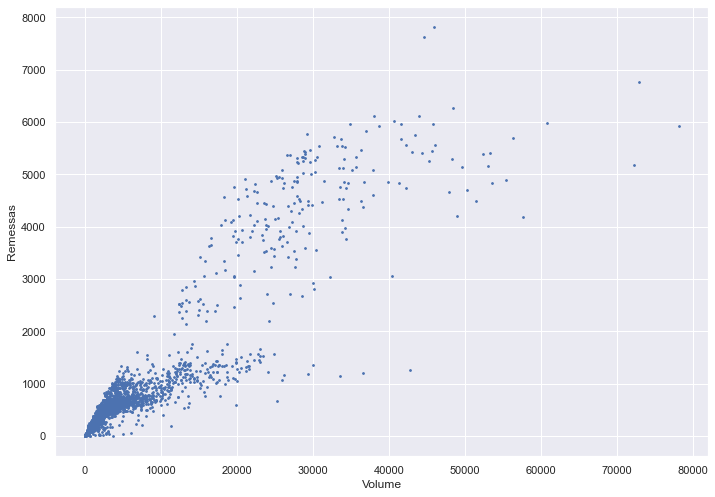

In [4]:
plt.clf()

plt.scatter(X['Volume'], y, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Realmente a relação entre essas duas *features* é diretamente proporcional. Com essa informação, pode-se concluir que a predição de um mês será do mesmo modelo: quanto maior o volume, maior o *target* Remessas.

## Separando os dados em treinamento e teste

Para ter uma métrica de cada modelo e o quão preciso é o mesmo, é utilizado o próprio conjunto de dados com o *target* que temos. É, então, selecionado um mês disponível no conjunto de dados para ser separado como teste. O resto dos meses serão utilizados para treinamento de cada modelo preditivo.

In [5]:
mes = 3
ano = 2020

Para fins de teste, foi escolhido o mês de Março de 2020. Qualquer outro mês existente no conjunto de dados "Dados Históricos" pode ser escolhido. 

In [6]:
X_treino, X_teste, y_treino, y_teste = gerarMesTeste(X, y, mes, 2020)

Text(0, 0.5, 'Remessas')

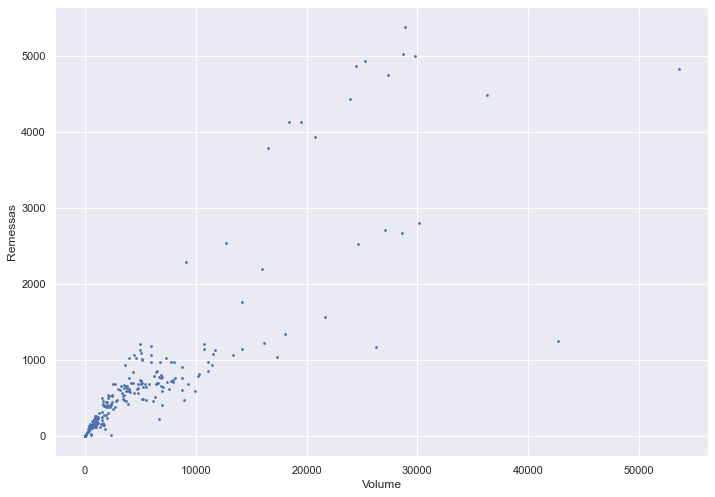

In [7]:
plt.clf()

plt.scatter(X_teste['Volume'], y_teste, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

## *Random Forest* convencional

Um dos modelos escolhidos para esse *case* foi o *Random Forest*. O *Random Forest* é um modelo pretidivo do tipo *ensemble*, ou seja, é um conjunto de outros modelos preditivos, nesse caso, a árvore de decisão. Esse modelo pode ser usado tanto para problemas de classificação quanto para regressão.

In [8]:
resultadoRF = gerarResultadoRandomForest(X_treino, X_teste, y_treino)

Após a criação do modelo *Random Forest* e seu treinamento, o resultado é calculado. Após isso, é comparado o mesmo com o valor real do mês, dado que temos esse valor no conjunto de dados.

Text(0, 0.5, 'Remessas')

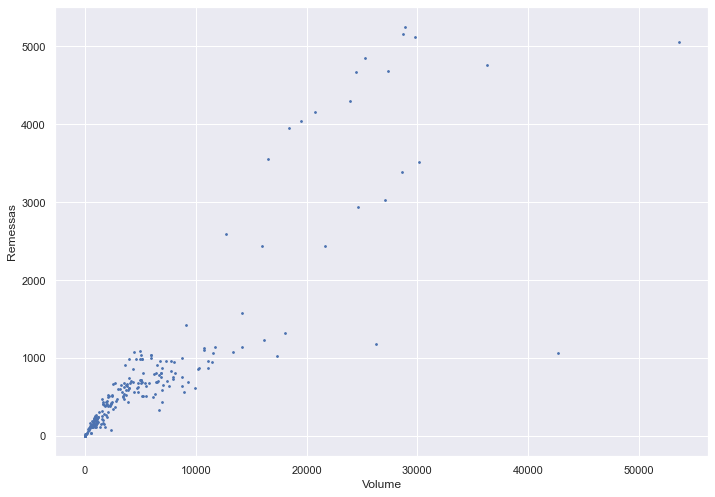

In [9]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoRF, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

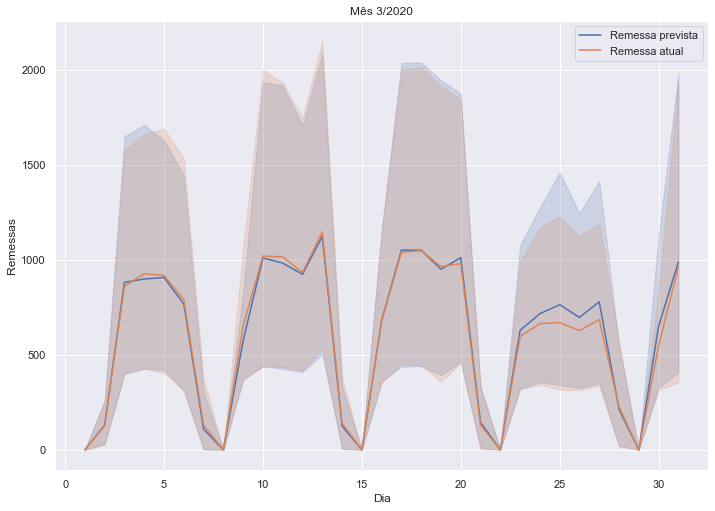

In [10]:
gerarGraficoMensal(X_treino, X_teste, y_treino, y_teste, resultadoRF, comecoMes = 0, fimMes = X_teste.shape[0], saveImage = True, name = 'RF mensal')

As linhas representam os valores médios de cada *Cluster*. As áreas em volta das linhas são os valores reais e sua flutuação. As linhas e as áreas estão bem próximas uma das outras, indicando que o modelo criado parece estar bom. Mas, o quão bom está?

In [11]:
MSerrorRF = mean_squared_error(y_teste, resultadoRF)

RMSerrorRF = mean_squared_error(y_teste, resultadoRF, squared = False)

MAerrorRF = mean_absolute_error(y_teste, resultadoRF)

print('Mean Squared Error: {}'.format(MSerrorRF))
print('Root Mean Squared Error: {}'.format(RMSerrorRF))
print('Mean Absolute Error: {}'.format(MAerrorRF)) 

Mean Squared Error: 11465.34870967742
Root Mean Squared Error: 107.07636858652529
Mean Absolute Error: 32.63412903225807


Dado que cada métrica pode variar de 0 até o infinito, parece que os resultados não são os melhores, apesar do gráfico nos mostrar que o resultado está bem próximo do valor original. Que tal ver os gráficos e as medidas isoladas de cada *Cluster*? Talvez um ou mais sejam um *outlier*, ou seja, algo fora do padrão, que pode ir contra ao que o modelo aprendeu. 

<Figure size 842.4x595.44 with 0 Axes>

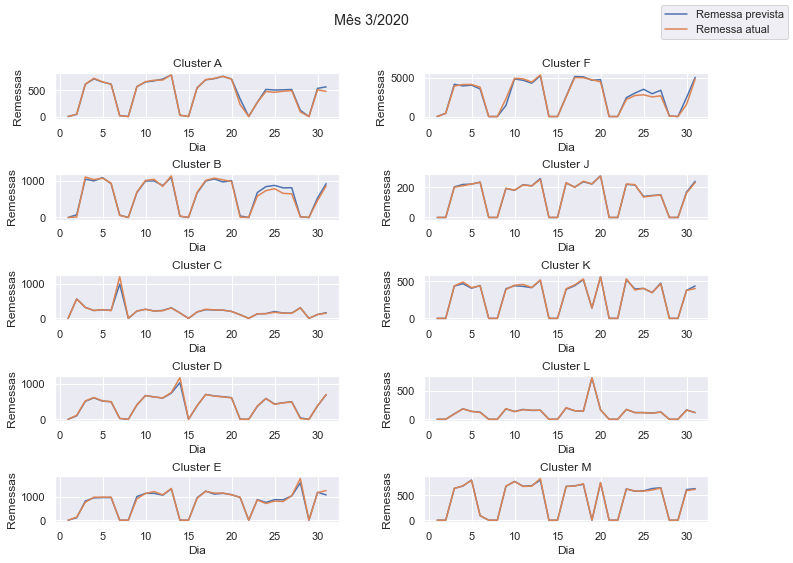

In [12]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_treino, y_teste, resultadoRF, comecoMes = 0, saveImage = True, name = 'clustersRF')

Só pelo gráfico, dá para ver que o modelo é até bem preciso no maior dos casos. Os *Clusters* que tem mais diferença entre o valor real e o predito são o B e o F. 

In [13]:
clusters = ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'K', 'L', 'M']

indexes = X_teste.index

for i in clusters:
    
    clusterIndexes = indexes[X_teste['Cluster_' + i] == 1].tolist()

    MSerrorRF = mean_squared_error(y_teste[clusterIndexes], resultadoRF[clusterIndexes])

    RMSerrorRF = mean_squared_error(y_teste[clusterIndexes], resultadoRF[clusterIndexes], squared = False)

    MAerrorRF = mean_absolute_error(y_teste[clusterIndexes], resultadoRF[clusterIndexes])

    print('No Cluster {}:'.format(i))
    print('Mean Squared Error: {}'.format(MSerrorRF))
    print('Root Mean Squared Error: {}'.format(RMSerrorRF))
    print('Mean Absolute Error: {}\n'.format(MAerrorRF))

No Cluster A:
Mean Squared Error: 813.7258774193551
Root Mean Squared Error: 28.52588083511805
Mean Absolute Error: 14.691612903225812

No Cluster B:
Mean Squared Error: 3444.1966193548387
Root Mean Squared Error: 58.68727817299793
Mean Absolute Error: 40.318064516129034

No Cluster C:
Mean Squared Error: 1544.4254419354834
Root Mean Squared Error: 39.2991786419956
Mean Absolute Error: 11.007419354838714

No Cluster D:
Mean Squared Error: 708.5464774193548
Root Mean Squared Error: 26.61853635005792
Mean Absolute Error: 9.83032258064517

No Cluster E:
Mean Squared Error: 3173.5144419354824
Root Mean Squared Error: 56.333954609413695
Mean Absolute Error: 32.69193548387096

No Cluster F:
Mean Squared Error: 104742.64772258064
Root Mean Squared Error: 323.63968811408256
Mean Absolute Error: 202.30387096774197

No Cluster J:
Mean Squared Error: 9.646977419354862
Root Mean Squared Error: 3.105958373731828
Mean Absolute Error: 2.010645161290325

No Cluster K:
Mean Squared Error: 108.330296774

Utilizando as métricas, é confirmado as suspeitas: enquanto a média do erro absoluto varia entre 2 e 30 nos outros *Clusters*, o B e o F têm a média de erro absoluto de 44 e 214, respectivamente.

O resultado será salvo como um arquivo em Excel.

In [14]:
gerarExcel(resultadoRF, X_teste, mes = mes, ano = ano, nome = 'RandomForest')

## *Random Forest* como um regressor inflado com zeros (*Zero-Inflated Regressor*)

Quando um conjunto de dados tem uma grande quantidade de valores no *target* como 0, isso pode atrapalhar o treinamento de um modelo regressor. Esses problemas são chamados de *zero-inflated*, ou inflados por zeros. Para resolver esse tipo de problema, a biblioteca scikit-lego tem a implementação de um *Zero-Inflated Regressor*, ou ZIR. 

A grande diferença desse modelo para o *Random Forest* convencional é que, durante o treino, este roda um classificador para treinar qual valor no *target* é 0 e qual não é. Após isso, os valores que são diferentes de 0 são utilizados para treinar outro modelo, dessa vez, um regressor. Como o *Random Forest* funciona para ambos os problemas, o ZIR utilizado nesse conjunto de dados utilizará o *Random Forest* tanto para a parte de classificação quanto para a parte de regressão.

In [15]:
resultadoZIR = gerarResultadoZIRRandomForest(X_treino, X_teste, y_treino)

Text(0, 0.5, 'Remessas')

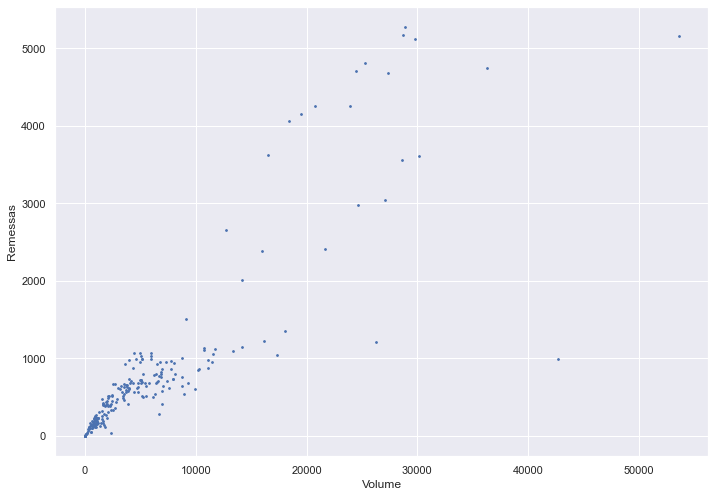

In [16]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoZIR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Então, o gráfico é gerado com o resultado.

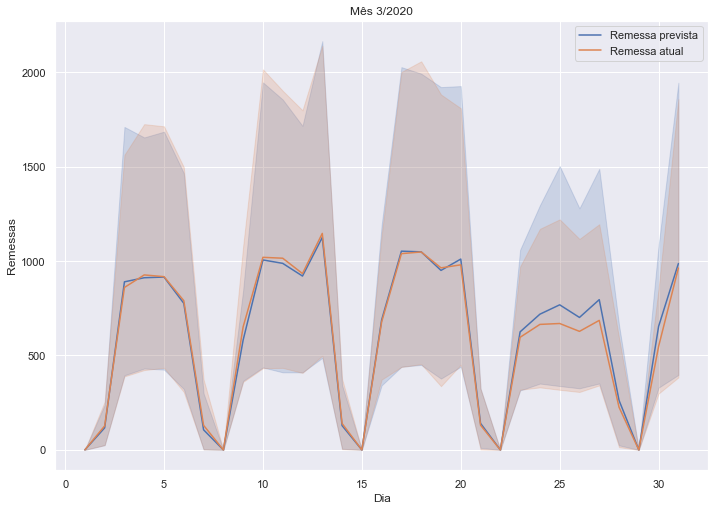

In [17]:
gerarGraficoMensal(X_treino, X_teste, y_treino, y_teste, resultadoZIR, comecoMes = 0, fimMes = X_teste.shape[0], saveImage = True, name = 'ZIR mensal')

Como antes, será exibido as suas métricas avaliativas.

In [18]:
MSerrorZIR = mean_squared_error(y_teste, resultadoZIR)

RMSerrorZIR = mean_squared_error(y_teste, resultadoZIR, squared = False)

MAerrorZIR = mean_absolute_error(y_teste, resultadoZIR)

print('Mean Squared Error: {}'.format(MSerrorZIR))
print('Root Mean Squared Error: {}'.format(RMSerrorZIR))
print('Mean Absolute Error: {}'.format(MAerrorZIR)) 

Mean Squared Error: 12793.347617741936
Root Mean Squared Error: 113.10768151519125
Mean Absolute Error: 34.14687096774193


Os resultados das métricas são melhores que o *Random Forest* convencional. Após isso, tem o gráfico comparativo de cada *Cluster* e suas métricas.

<Figure size 842.4x595.44 with 0 Axes>

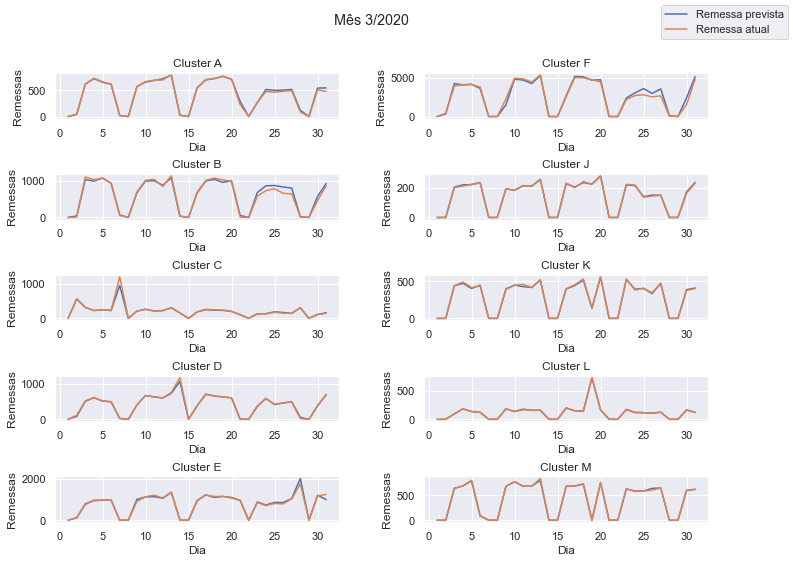

In [19]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_treino, y_teste, resultadoZIR, comecoMes = 0, saveImage = True, name = 'clustersZIR')

Como antes, os *Clusters* B e F apresentam a maior diferença entre predição e valor real. Mas, os *Clusters* individuais tiveram melhora em relação ao *Random Forest* convencional?

In [20]:
clusters = ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'K', 'L', 'M']

indexes = X_teste.index

for i in clusters:
    
    clusterIndexes = indexes[X_teste['Cluster_' + i] == 1].tolist()

    MSerrorZIR = mean_squared_error(y_teste[clusterIndexes], resultadoZIR[clusterIndexes])

    RMSerrorZIR = mean_squared_error(y_teste[clusterIndexes], resultadoZIR[clusterIndexes], squared = False)

    MAerrorZIR = mean_absolute_error(y_teste[clusterIndexes], resultadoZIR[clusterIndexes])

    print('No Cluster {}:'.format(i))
    print('Mean Squared Error: {}'.format(MSerrorZIR))
    print('Root Mean Squared Error: {}'.format(RMSerrorZIR))
    print('Mean Absolute Error: {}\n'.format(MAerrorZIR))

No Cluster A:
Mean Squared Error: 467.04095806451613
Root Mean Squared Error: 21.611130420792804
Mean Absolute Error: 12.930645161290325

No Cluster B:
Mean Squared Error: 4094.390522580644
Root Mean Squared Error: 63.98742472221119
Mean Absolute Error: 43.436129032258066

No Cluster C:
Mean Squared Error: 2141.184580645161
Root Mean Squared Error: 46.27293572538014
Mean Absolute Error: 12.461935483870965

No Cluster D:
Mean Squared Error: 500.2319741935488
Root Mean Squared Error: 22.365866274158684
Mean Absolute Error: 9.64774193548387

No Cluster E:
Mean Squared Error: 5095.32808064516
Root Mean Squared Error: 71.38156681276449
Mean Absolute Error: 36.02548387096774

No Cluster F:
Mean Squared Error: 115443.18447096775
Root Mean Squared Error: 339.76931066676366
Mean Absolute Error: 212.53806451612903

No Cluster J:
Mean Squared Error: 13.027151612903214
Root Mean Squared Error: 3.6093145627533234
Mean Absolute Error: 2.5422580645161283

No Cluster K:
Mean Squared Error: 78.26029032

A melhora não foi muito significativa, mas foi, mesmo assim, uma melhora.

De novo, os valores foram salvos em um arquivo Excel.

In [21]:
gerarExcel(resultadoZIR, X_teste, mes = mes, ano = ano, nome = 'ZIR_RandomForest')

## Regressão linear padrão

A Regressão Linear é um algoritmo que treina a partir de *feature*(s) do conjunto de dados e traça uma linha no gráfico que representa a correlação entre a(s) *feature*(s) e o *target*. A linha é formada a partir desta fórmula:

> y = $\theta$ * x + b

sendo:

- $\theta$ o peso da *feature*, que representa o impacto que a mesma tem quando treinando o modelo.

- b o interceptor, ou, o termo de viés, que representa a tendência do resultado da regressão de se deslocar de maneira consistente, a partir da origem, quando perto de unidades b.

In [22]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


Após criar e treinar o modelo de regressão linear, é gerado o resultado em um gráfico. 

Text(0, 0.5, 'Remessas')

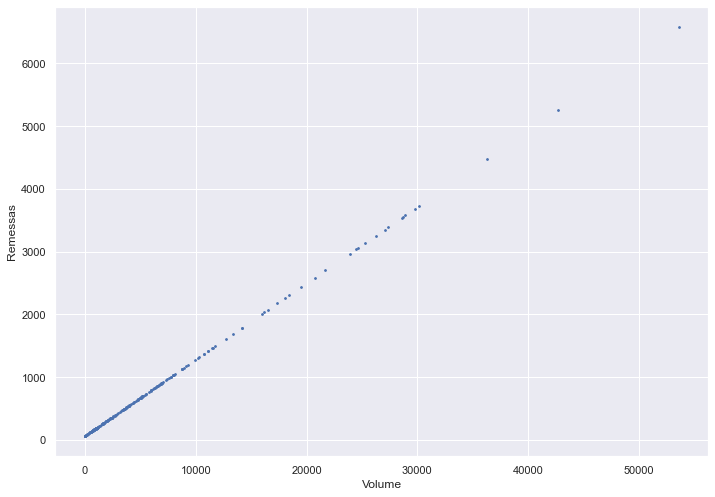

In [23]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Como esperado, o resultado da regressão linear gerou pontos muito mais ordenados que as versões de *Random Forest*.

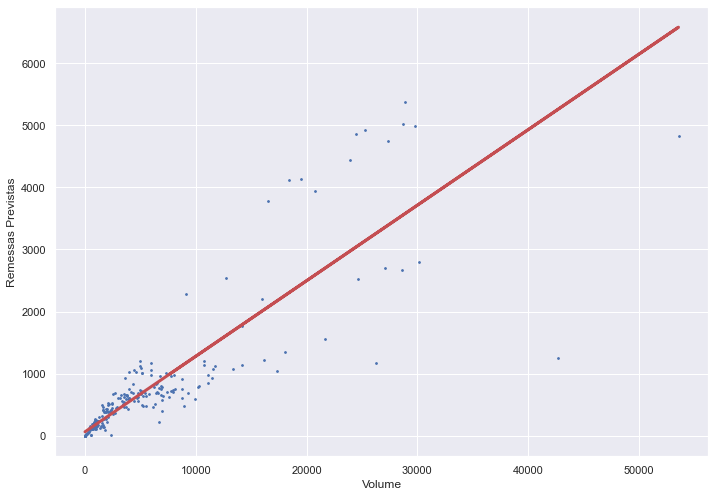

In [24]:
gerarGraficoLinear(X_teste, y_teste, resultadoLR, saveImage = True, name = 'LR linear')

E esse é o gráfico que foi gerado, comparando o valor real do *target* com a linha gerada a partir da Regressão Linear.

Comparando esse gráfico e o resultado com os gráficos e os resultados, A regressão linear não parece ser melhor que os modelos já vistos.

O gráfico que representa a previsão do mês feita pelo modelo e as medidas avaliativas da previsão são exibidos a seguir.

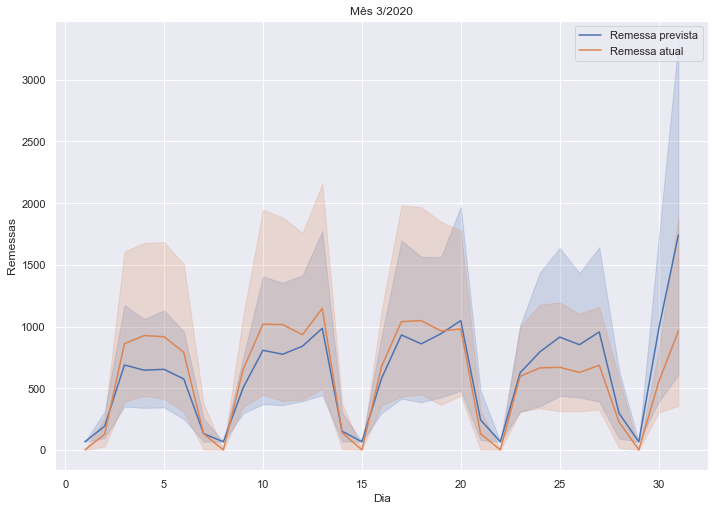

In [25]:
gerarGraficoMensal(X_treino, X_teste, y_treino, y_teste, resultadoLR, comecoMes = 0, fimMes = X_teste.shape[0], saveImage = True, name = 'LR mensal')

In [26]:
MSerrorLR = mean_squared_error(y_teste, resultadoLR)

RMSerrorLR = mean_squared_error(y_teste, resultadoLR, squared = False)

MAerrorLR = mean_absolute_error(y_teste, resultadoLR)

print('Mean Squared Error: {}'.format(MSerrorLR))
print('Root Mean Squared Error: {}'.format(RMSerrorLR))
print('Mean Absolute Error: {}'.format(MAerrorLR)) 

Mean Squared Error: 227058.3625372308
Root Mean Squared Error: 476.50641395182794
Mean Absolute Error: 223.55294967485082


Uma medida extra que pode ser utilizada para avaliar o quão bom é esse modelo de Regressão Linear é a medida R^2. Essa medida revela quanto a variação do resultado pode ser explicada em relação à *feature* escolhida para treinar o modelo. Um valor perfeito é 1, podendo atingir valores negativos (pois o modelo pode ser arbitrariamente ruim em prever o modelo). Quando o modelo tem R^2 = 0, ele está acertando todas as predições.

In [27]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.7581803752241201


<Figure size 842.4x595.44 with 0 Axes>

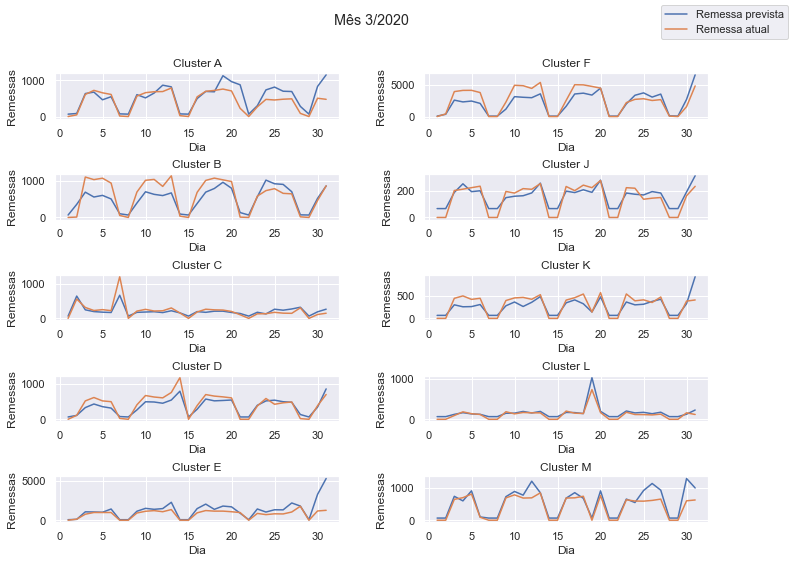

In [28]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_treino, y_teste, resultadoLR, comecoMes = 0, saveImage = True, name = 'clustersRF')

In [29]:
clusters = ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'K', 'L', 'M']

indexes = X_teste.index

for i in clusters:
    
    clusterIndexes = indexes[X_teste['Cluster_' + i] == 1].tolist()

    MSerrorLR = mean_squared_error(y_teste[clusterIndexes], resultadoLR[clusterIndexes])

    RMSerrorLR = mean_squared_error(y_teste[clusterIndexes], resultadoLR[clusterIndexes], squared = False)

    MAerrorLR = mean_absolute_error(y_teste[clusterIndexes], resultadoLR[clusterIndexes])

    print('No Cluster {}:'.format(i))
    print('Mean Squared Error: {}'.format(MSerrorLR))
    print('Root Mean Squared Error: {}'.format(RMSerrorLR))
    print('Mean Absolute Error: {}\n'.format(MAerrorLR))

No Cluster A:
Mean Squared Error: 53155.87166948258
Root Mean Squared Error: 230.55557175978763
Mean Absolute Error: 157.11299651781215

No Cluster B:
Mean Squared Error: 66316.78595829784
Root Mean Squared Error: 257.52045735882393
Mean Absolute Error: 206.5000956412467

No Cluster C:
Mean Squared Error: 13391.048282747539
Root Mean Squared Error: 115.7196970387822
Mean Absolute Error: 72.56928383822995

No Cluster D:
Mean Squared Error: 18192.501619734663
Root Mean Squared Error: 134.87958192304225
Mean Absolute Error: 111.54846513909526

No Cluster E:
Mean Squared Error: 839211.2198300558
Root Mean Squared Error: 916.0847230633507
Mean Absolute Error: 499.1536507980869

No Cluster F:
Mean Squared Error: 1206167.7709622758
Root Mean Squared Error: 1098.2566962974893
Mean Absolute Error: 848.4738645715629

No Cluster J:
Mean Squared Error: 2327.5803829210813
Root Mean Squared Error: 48.245003709411
Mean Absolute Error: 43.696515890936816

No Cluster K:
Mean Squared Error: 19539.282912

Como esperado, a Regressão Linear tem uma média de erro muito maior que os modelos baseados em *Random Forest*. 

Um jeito de aprimorar a Regressão Linear é utilizar mais do que uma *feature* para treinar o modelo. 

In [30]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 8)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana']


Text(0, 0.5, 'Remessas')

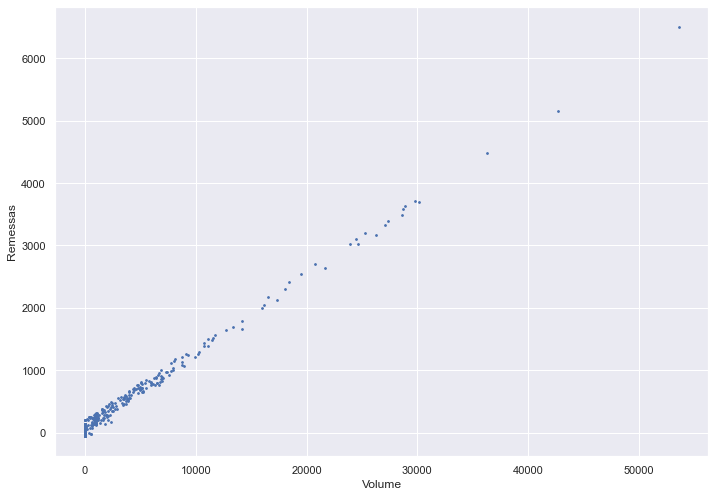

In [31]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

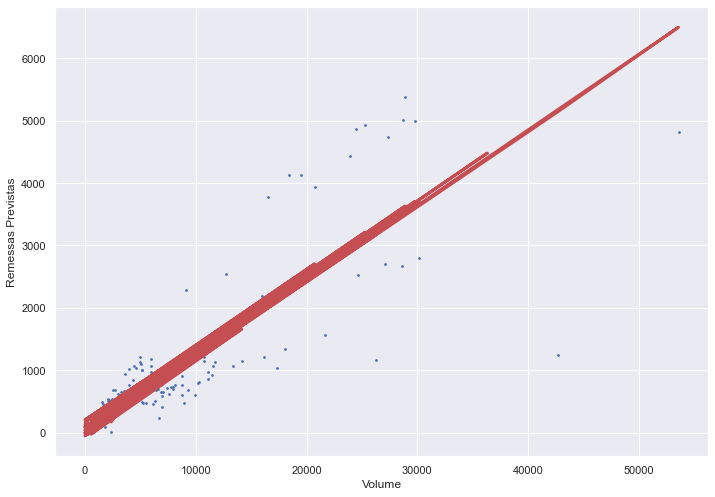

In [32]:
gerarGraficoLinear(X_teste, y_teste, resultadoLR, saveImage = True, name = 'LR linear')

A linha que intercepta os pontos passa a ser uma função mais complexa que somente uma função de 1º grau. Porém, a complexidade torna ela mais próxima do que os valores reais são, melhorando, assim, a predição do modelo.

In [33]:
MSerrorLR = mean_squared_error(y_teste, resultadoLR)

RMSerrorLR = mean_squared_error(y_teste, resultadoLR, squared = False)

MAerrorLR = mean_absolute_error(y_teste, resultadoLR)

print('Mean Squared Error: {}'.format(MSerrorLR))
print('Root Mean Squared Error: {}'.format(RMSerrorLR))
print('Mean Absolute Error: {}'.format(MAerrorLR)) 

Mean Squared Error: 209445.00857526233
Root Mean Squared Error: 457.651623590764
Mean Absolute Error: 214.25583213612583


In [34]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.7769387886933865


Como o modelo se comportará, então, se usarmos todas as *features*?

In [35]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 18)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana', 'Cluster_A', 'Cluster_B', 'Cluster_C', 'Cluster_D', 'Cluster_E', 'Cluster_F', 'Cluster_J', 'Cluster_K', 'Cluster_L', 'Cluster_M']


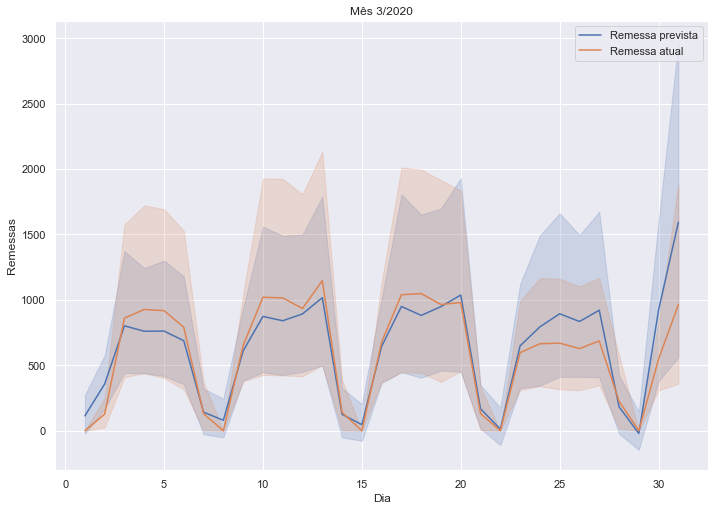

In [36]:
gerarGraficoMensal(X_treino, X_teste, y_treino, y_teste, resultadoLR, comecoMes = 0, fimMes = X_teste.shape[0], saveImage = True, name = 'LR mensal')

<Figure size 842.4x595.44 with 0 Axes>

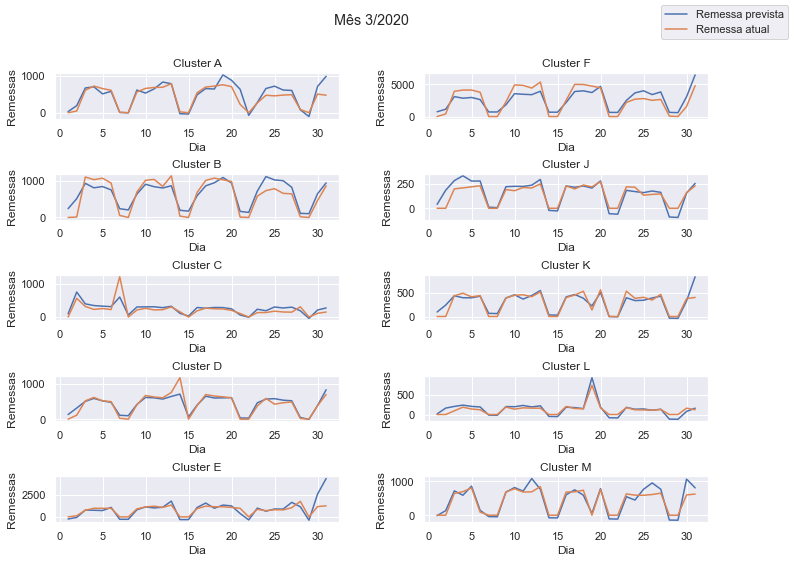

In [37]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_treino, y_teste, resultadoLR, comecoMes = 0, saveImage = True, name = 'clustersRF')

Parece um pouco melhor em relação a antes, mas não muito promissor... A seguir, as métricas:

In [38]:
MSerrorLR = mean_squared_error(y_teste, resultadoLR)

RMSerrorLR = mean_squared_error(y_teste, resultadoLR, squared = False)

MAerrorLR = mean_absolute_error(y_teste, resultadoLR)

print('Mean Squared Error: {}'.format(MSerrorLR))
print('Root Mean Squared Error: {}'.format(RMSerrorLR))
print('Mean Absolute Error: {}'.format(MAerrorLR)) 

Mean Squared Error: 155414.88782165022
Root Mean Squared Error: 394.2269496389741
Mean Absolute Error: 200.23646060164367


In [39]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.8344814547341125


Um resultado mais parecido com os obtidos pelo *Random Forest* e sua versão ZIR.

In [40]:
gerarExcel(resultadoLR, X_teste, mes = mes, ano = ano, nome = 'LinearRegression')

## Regressão linear utilizando *Ridge Regressor*

In [41]:
resultadoRR = gerarResultadoRidgeRegression(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


Text(0, 0.5, 'Remessas')

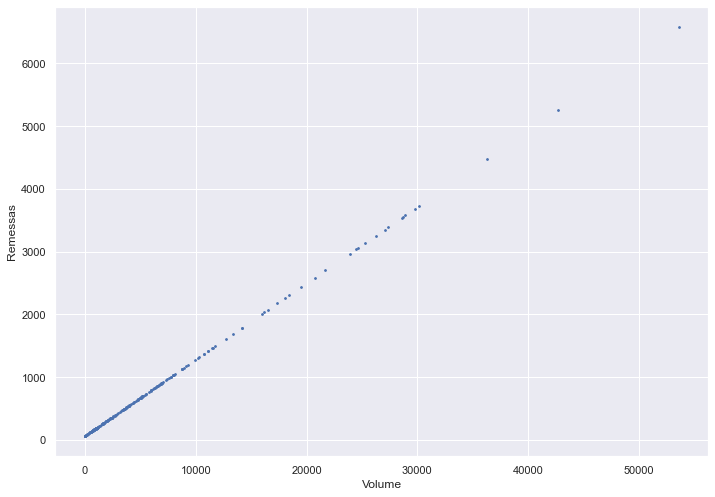

In [110]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoRR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

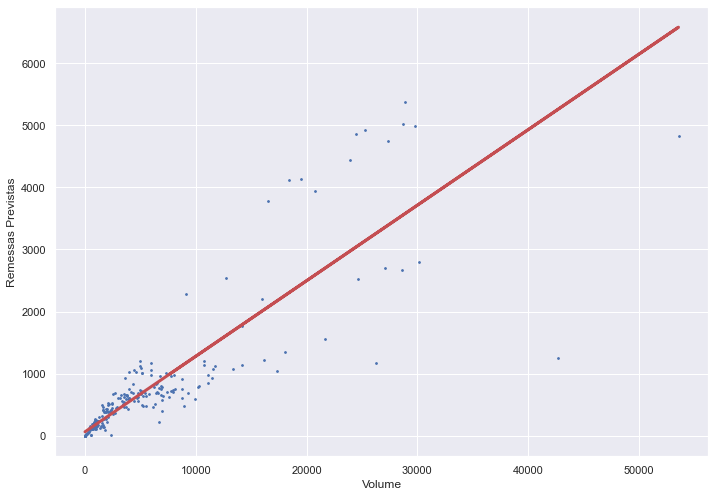

In [112]:
gerarGraficoLinear(X_teste, y_teste, resultadoRR, saveImage = True, name = 'RR linear')

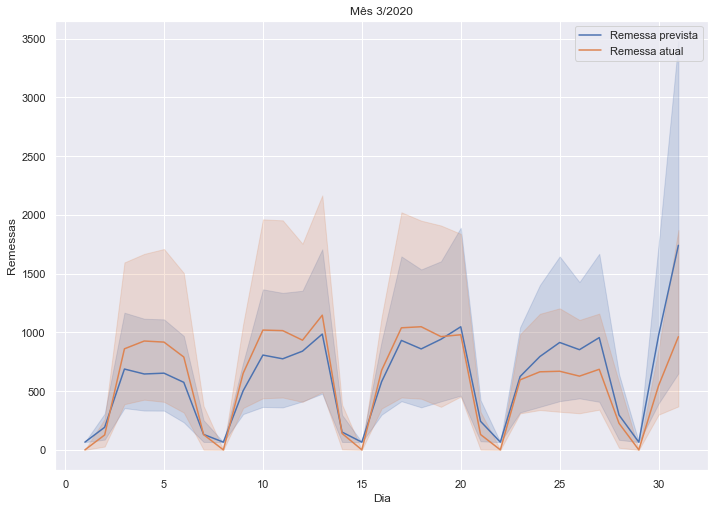

In [113]:
gerarGraficoMensal(X_treino, X_teste, y_treino, y_teste, resultadoRR, comecoMes = 0, fimMes = X_teste.shape[0], saveImage = True, name = 'RR mensal')

In [114]:
MSerrorRR = mean_squared_error(y_teste, resultadoRR)

RMSerrorRR = mean_squared_error(y_teste, resultadoRR, squared = False)

MAerrorRR = mean_absolute_error(y_teste, resultadoRR)

print('Mean Squared Error: {}'.format(MSerrorRR))
print('Root Mean Squared Error: {}'.format(RMSerrorRR))
print('Mean Absolute Error: {}'.format(MAerrorRR)) 

Mean Squared Error: 227058.3625368482
Root Mean Squared Error: 476.50641395142645
Mean Absolute Error: 223.55294967516957


In [ ]:
r2RR = r2_score(y_teste, resultadoRR)

print('R^2 Score: {}'.format(r2RR))

R^2 Score: 0.7581803752241201


<Figure size 842.4x595.44 with 0 Axes>

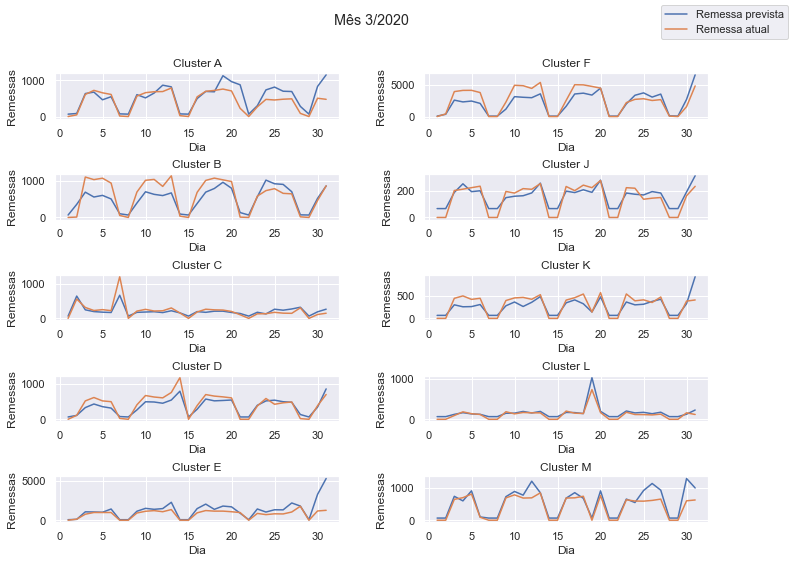

In [115]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_treino, y_teste, resultadoRR, comecoMes = 0, saveImage = True, name = 'clustersRF')

In [116]:
clusters = ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'K', 'L', 'M']

indexes = X_teste.index

for i in clusters:
    
    clusterIndexes = indexes[X_teste['Cluster_' + i] == 1].tolist()

    MSerrorRR = mean_squared_error(y_teste[clusterIndexes], resultadoRR[clusterIndexes])

    RMSerrorRR = mean_squared_error(y_teste[clusterIndexes], resultadoRR[clusterIndexes], squared = False)

    MAerrorRR = mean_absolute_error(y_teste[clusterIndexes], resultadoRR[clusterIndexes])

    print('No Cluster {}:'.format(i))
    print('Mean Squared Error: {}'.format(MSerrorRR))
    print('Root Mean Squared Error: {}'.format(RMSerrorRR))
    print('Mean Absolute Error: {}\n'.format(MAerrorRR))

No Cluster A:
Mean Squared Error: 53155.87166926483
Root Mean Squared Error: 230.5555717593154
Mean Absolute Error: 157.11299651816444

No Cluster B:
Mean Squared Error: 66316.78595833051
Root Mean Squared Error: 257.5204573588873
Mean Absolute Error: 206.5000956419474

No Cluster C:
Mean Squared Error: 13391.048282790362
Root Mean Squared Error: 115.71969703896723
Mean Absolute Error: 72.56928383834205

No Cluster D:
Mean Squared Error: 18192.501619708764
Root Mean Squared Error: 134.87958192294624
Mean Absolute Error: 111.54846513925482

No Cluster E:
Mean Squared Error: 839211.2198199887
Root Mean Squared Error: 916.084723057856
Mean Absolute Error: 499.15365079495047

No Cluster F:
Mean Squared Error: 1206167.7709689129
Root Mean Squared Error: 1098.256696300511
Mean Absolute Error: 848.4738645743471

No Cluster J:
Mean Squared Error: 2327.580383009056
Root Mean Squared Error: 48.24500371032275
Mean Absolute Error: 43.69651589140494

No Cluster K:
Mean Squared Error: 19539.28291227

In [117]:
gerarExcel(resultadoRR, X_teste, mes = mes, ano = ano, nome = 'RidgeRegression')